In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import files
upload = files.upload()

Saving pocm.csv to pocm.csv


In [306]:
data = pd.read_csv("pocm.csv", parse_dates=True)
data.drop("Unnamed: 0", axis=1, inplace=True)
data.head()

,Checkout_Date,Order_Quantity
0,2018-12-04,1
1,2018-12-04,1
2,2018-12-05,5
3,2018-12-05,10
4,2018-12-05,20


In [307]:
data.columns = ["Date","Quantity"]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160577 entries, 0 to 160576
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Date      160577 non-null  object
 1   Quantity  160577 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


In [308]:
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160577 entries, 2018-12-04 to 2020-05-15
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   Quantity  160577 non-null  int64
dtypes: int64(1)
memory usage: 2.5 MB


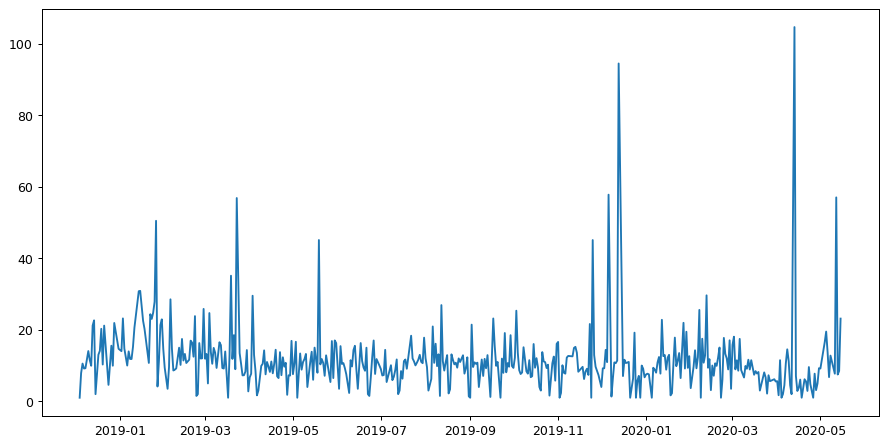

In [326]:
data = data.resample("D").mean().dropna()
plt.figure(figsize=(12,6),dpi=90)
plt.plot(data)

In [327]:
test = np.log(data["2020-05-01":])
train = np.log(data[:"2020-05-01"])

In [328]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [329]:
scaled_test

array([[0.47629322],
       [0.60318924],
       [0.63875159],
       [0.56228581],
       [0.41119692],
       [0.5478585 ],
       [0.4394664 ],
       [0.86943413],
       [0.43298119],
       [0.45986399],
       [0.67539163]])

In [333]:
from keras.preprocessing.sequence import TimeseriesGenerator
#look_back
n_input = 8
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [334]:
generator[0]

(array([[[0.        ],
         [0.44436854],
         [0.50655914],
         [0.47657072],
         [0.47828658],
         [0.56833142],
         [0.52623335],
         [0.49375419]]]), array([[0.65635075]]))

In [335]:
model = Sequential()
model.add(LSTM(100,activation="tanh", input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")


In [336]:
model.fit(generator, epochs=80)

Epoch 1/80
452/452 [==============================] - 6s 8ms/step - loss: 0.0292
Epoch 2/80
452/452 [==============================] - 4s 8ms/step - loss: 0.0275
Epoch 3/80
452/452 [==============================] - 3s 7ms/step - loss: 0.0270
Epoch 4/80
452/452 [==============================] - 4s 8ms/step - loss: 0.0271
Epoch 5/80
452/452 [==============================] - 3s 7ms/step - loss: 0.0267
Epoch 6/80
452/452 [==============================] - 3s 7ms/step - loss: 0.0269
Epoch 7/80
452/452 [==============================] - 4s 8ms/step - loss: 0.0262
Epoch 8/80
452/452 [==============================] - 3s 8ms/step - loss: 0.0263
Epoch 9/80
452/452 [==============================] - 4s 8ms/step - loss: 0.0261
Epoch 10/80
452/452 [==============================] - 3s 7ms/step - loss: 0.0261
Epoch 11/80
452/452 [==============================] - 3s 7ms/step - loss: 0.0266
Epoch 12/80
452/452 [==============================] - 3s 6ms/step - loss: 0.0260
Epoch 13/80
452/452 [====

In [337]:
#prediction
last_train_b = scaled_train[-n_input:]
last_train_b = last_train_b.reshape((1,n_input,n_features))
model.predict(last_train_b)

array([[0.39158404]], dtype=float32)

In [338]:
scaled_test[0]

array([0.47629322])

In [339]:
predictions = []

first_batch = scaled_train[-n_input:]
current_batch = first_batch.reshape((1,n_input,n_features))

for i in range(len(scaled_test)):
  #get the prediction values for first batch
  current_pred = model.predict(current_batch)[0]

  #append the prediction into array
  predictions.append(current_pred)

  #remove the first value
  curr_remv_val = current_batch[:,1:,:]

  #update the batch
  current_batch= np.append(curr_remv_val,[[current_pred]], axis=1)

In [340]:
predictions

[array([0.39158404], dtype=float32),
 array([0.2982365], dtype=float32),
 array([0.4532388], dtype=float32),
 array([0.3894425], dtype=float32),
 array([0.4491318], dtype=float32),
 array([0.4741271], dtype=float32),
 array([0.49206218], dtype=float32),
 array([0.42987916], dtype=float32),
 array([0.42125583], dtype=float32),
 array([0.44117427], dtype=float32),
 array([0.45693967], dtype=float32)]

In [341]:
forecast = scaler.inverse_transform(predictions)

In [342]:
test_f = test.copy()
test_f.columns = ["Actual values"]
test_f["Forecast"] = forecast
test_f = np.exp(test_f)
test_f

,Actual values,Forecast
Date,,
2020-05-01,9.164634,6.180194
2020-05-04,16.536585,4.003497
2020-05-05,19.511111,8.232752
2020-05-06,13.671642,6.118940
2020-05-07,6.770492,8.076978
2020-05-08,12.784314,9.072763
2020-05-11,7.721910,9.862080
2020-05-12,57.050847,7.385135
2020-05-13,7.492462,7.094786


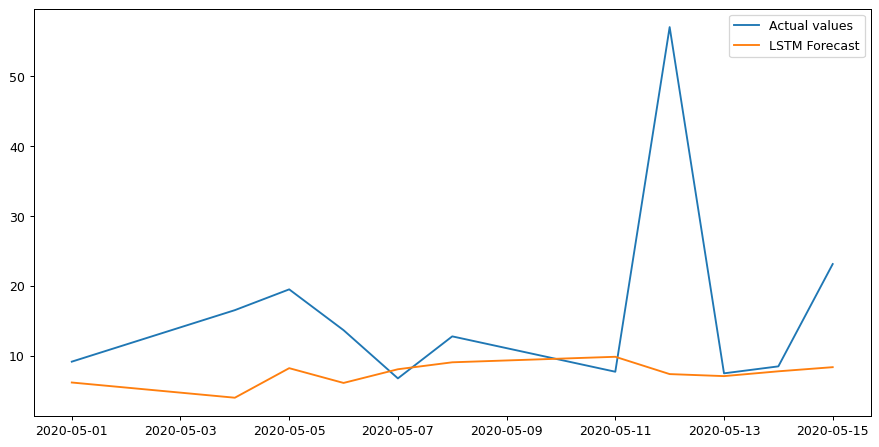

In [343]:
plt.figure(figsize=(12,6),dpi=90)
plt.plot(test_f["Actual values"], label="Actual values")
plt.plot(test_f["Forecast"], label="LSTM Forecast")
plt.legend(loc="best")
plt.show()

In [344]:
test_f.to_csv("prediction.csv")
files.download("prediction.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>